In [1]:
import torch
import matplotlib.pyplot as plt
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
chrom_hmm_data = torch.load('ChromHMM_states.pt')

In [12]:
states = {
    'Info':[],
    'States':[]
}
for chrom,data1 in chrom_hmm_data.items():
    for region_idx,data2 in data1.items():
        states['Info'].append( (chrom,region_idx) )
        states['States'].append( torch.from_numpy(data2['states'] ))

states['States'] = torch.stack(states['States'],dim=0)

# Coarsen data
states['Coarse'] = {}
resolution = 20_000
for activation,val in [('active',1),('inactive',2),('repressed',3)]:

    states['Coarse'][activation] = torch.cat(
        [
            (states['States'][:,i:i+resolution] == val).float().mean(-1,keepdim=True) for i in range(0,states['States'].shape[-1],resolution)
        ],
        dim=-1
    )
    
del chrom_hmm_data

In [34]:
def mean_activations(num_subregion_beads,states=states):

    N = states['Coarse']['active'].shape[-1]
    n = num_subregion_beads
    contributions = {
        'regions':states['Info'],
        'active':[],
        'inactive':[],
        'repressed':[]
    }
    for activation in ['active','inactive','repressed']:

        i = 0
        j = n
        
        while i+n <= N:

            contributions[activation].append(
                states['Coarse'][activation][:,i:i+n].mean(-1,keepdim=True)
            )
            i+= 1
            j+= 1

        contributions[activation] = torch.cat(contributions[activation],dim=-1)
    
    return contributions

In [35]:
marks = torch.load('active_inactive_full_scan_data.pt')['all_stats']

In [71]:
def parse_filename(fn):

    f = fn.split('_')
    chrom = f[-1].split('.')[0]
    region_idx = int(f[1])

    return chrom, region_idx

window_sizes = list(range(2,11)) # From the mark file 

mean_ChromHMM_data = [
    mean_activations(ws) for ws in window_sizes
]

all_mark_data = []
all_ChromHMM_data = []
for fn,mark_data in marks.items():

    chrom, region_idx = parse_filename(fn)
    
    #k = mean_ChromHMM_data['regions'][].index((chrom,region_idx))

    for i,ws in enumerate(window_sizes):
        all_mark_data.append( mark_data['K27'][i].flatten() )

        k = mean_ChromHMM_data[i]['regions'].index((chrom,region_idx))
        
        all_ChromHMM_data.append( mean_chrom_data[i]['repressed'][k,:].flatten() )

all_mark_data = torch.cat(all_mark_data).log()
if all_mark_data[all_mark_data.isfinite()].min() < 0:
    all_mark_data-= all_mark_data[all_mark_data.isfinite()].min()
all_mark_data/= all_mark_data[all_mark_data.isfinite()].max()
all_mark_data = all_mark_data.numpy()
all_ChromHMM_data = torch.cat(all_ChromHMM_data).log().numpy()


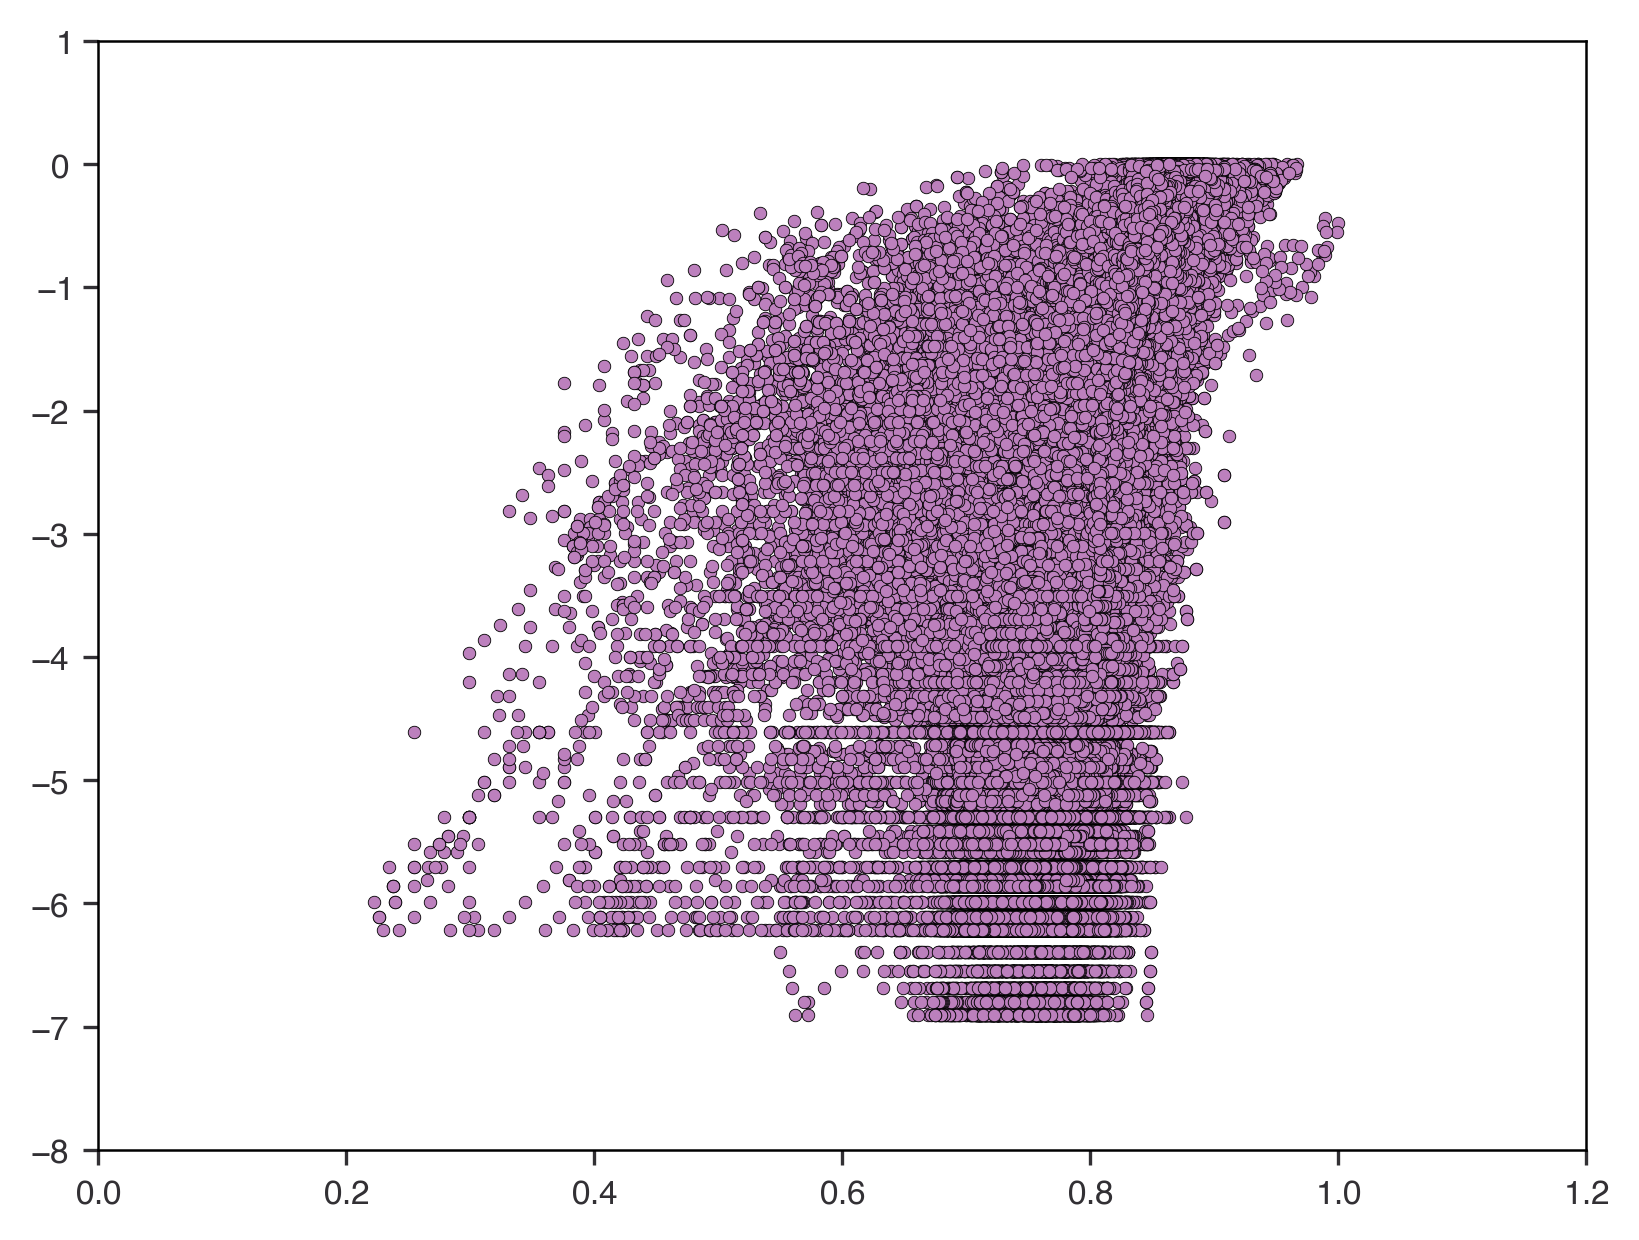

In [72]:
plt.plot(all_mark_data,all_ChromHMM_data,'.')

Text(0, 0.5, 'ChromHMM fraction values')

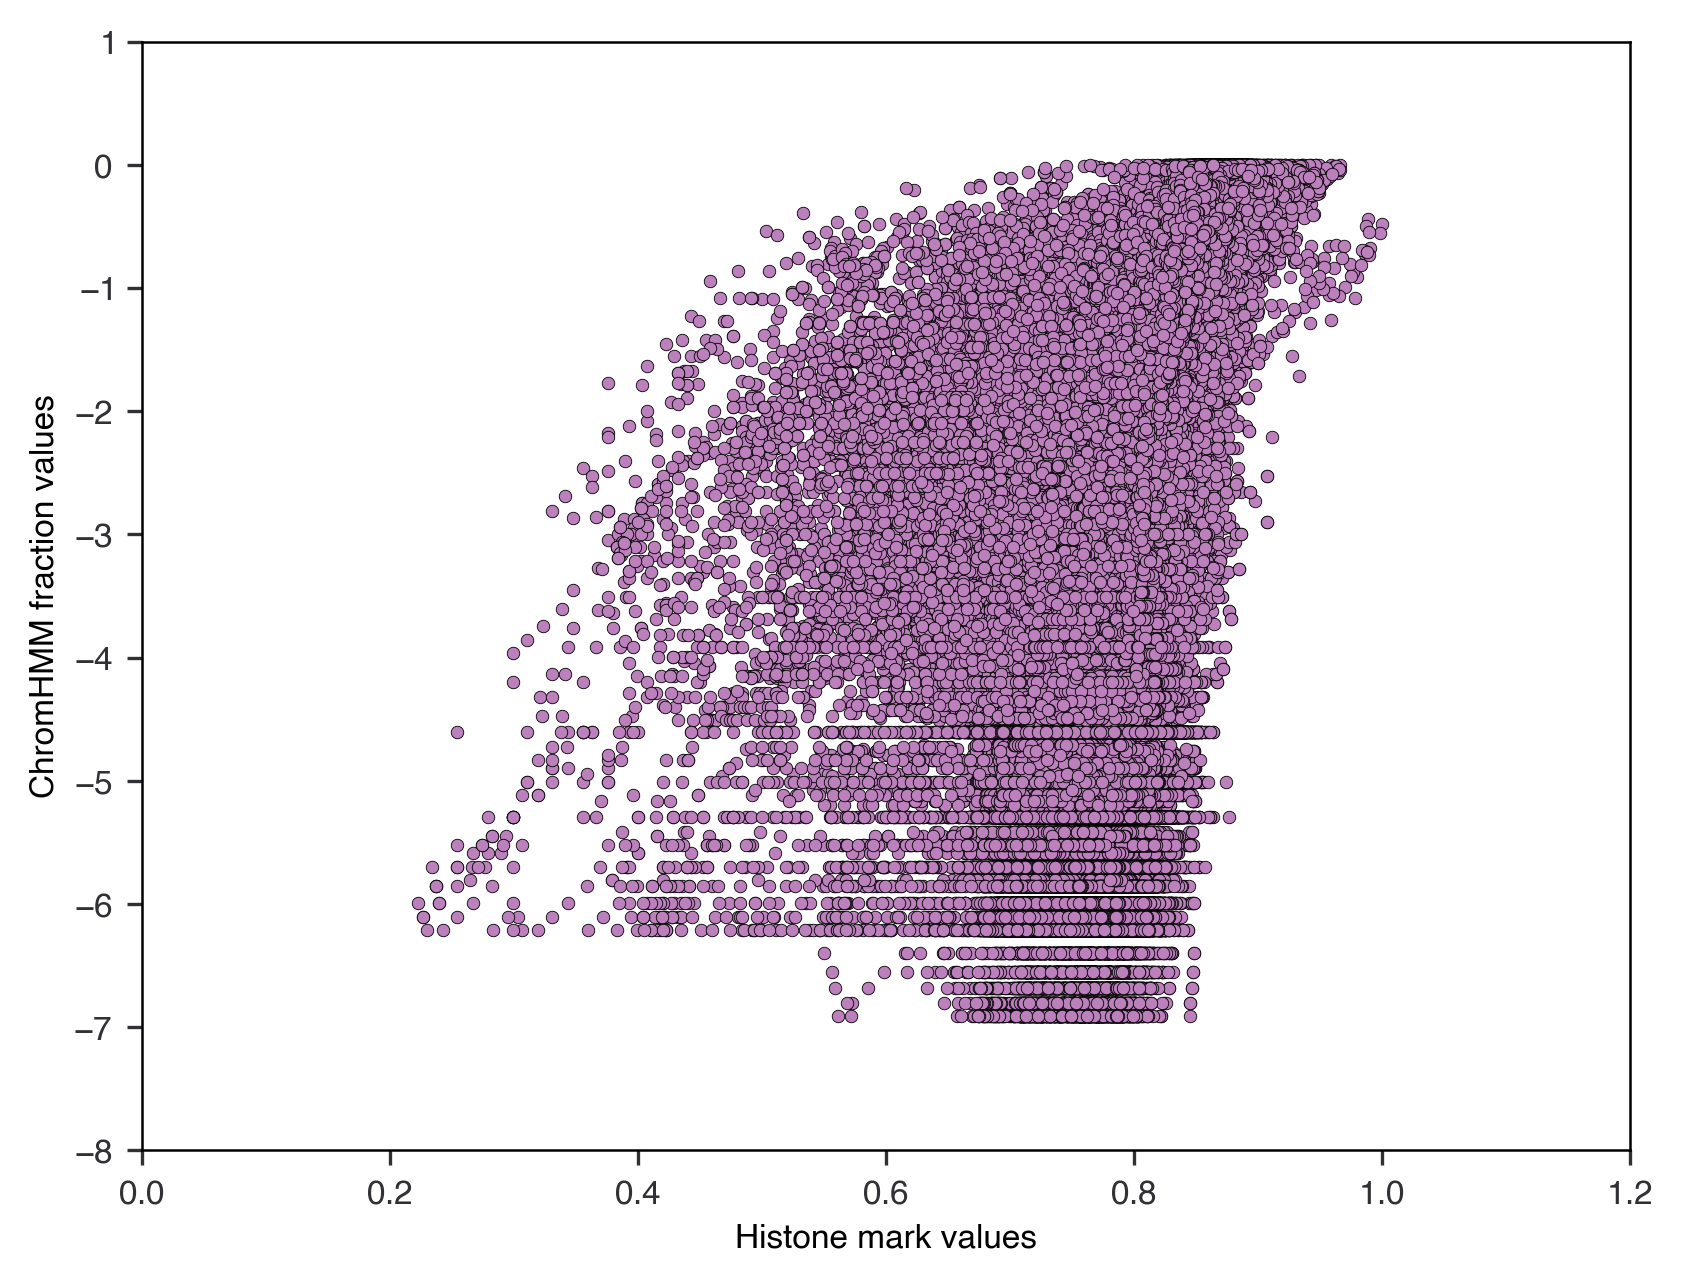

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(all_mark_data,all_ChromHMM_data,'.')

ax.set_xlabel('Histone mark values')
ax.set_ylabel('ChromHMM fraction values')

In [73]:
a = torch.from_numpy(all_mark_data).float()
b = torch.from_numpy(all_ChromHMM_data).float()

idx = a.isfinite() & b.isfinite()
a = a[idx]
b = b[idx]
del idx 

print(
    torch.corrcoef(
        torch.stack(
            [
                a,
                b
            ],
            dim=0
        )
    )
)
del a,b

tensor([[1.0000, 0.6005],
        [0.6005, 1.0000]])
